In [246]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from rastermap import Rastermap
from scipy.signal import savgol_filter
cmap = plt.cm.get_cmap('viridis_r')

import os
import scipy.io
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr, zscore
from scipy.io import savemat
import random
from utils import daily_blocks, extract_all_licks, get_tone_response_df, block_stim_evoke_response, load_behavior_txt
from sklearn.decomposition import PCA
plt.rcParams['axes.facecolor'] = 'white'
outcome_list = ['Hit', 'Miss', 'FA', 'CR']
mouse_names = ['jl009', 'fz017', 'fz009', 'fz006']
data_paths = ["Z:/Jenni/jl009/mattc.mat",
             "W:/Jenni/fz017/mattc.mat",
             "Y:/Jenni/fz009/behavimaging.mat",
             "Y:/sarah/fz006/behavimaging.mat"]

mouse_id = 1
mouse_name = mouse_names[mouse_id]
data_path = data_paths[mouse_id]
mat = scipy.io.loadmat(data_path)

toneorder = [45254.834, 8000, 13454.34264, 4756.82846, 5656.854249, 22627.417, 64000, 53817.37058, 4000, 9513.65692,
             16000, 6727.171322, 19027.31384, 26908.6852, 32000, 11313.7085, 38054.62768];
print(len(toneorder))
if mouse_name == 'jl009':
    target_freq = 9514
    foil_freq = 16000
    frame_shift = 0 # 1
elif mouse_name == 'fz017':
    foilid = 9514
    targetid = 5657
    frame_shift = 0 # -9

17


In [247]:
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'mattc'])


In [248]:
data = mat['mattc']
print(data.shape, data.dtype)

(1, 1) [('F', 'O'), ('param', 'O')]


In [249]:
F = data['F']
F = F[0, 0]
F = np.roll(F, frame_shift)
print(F.shape, F.dtype)
param = data['param']
param = param[0, 0]
print(param.shape, param.dtype)

(1153, 8500) float32
(1153, 3) uint8


Text(0.5, 1.0, 'raw response of the first two tones without any shift, fz017')

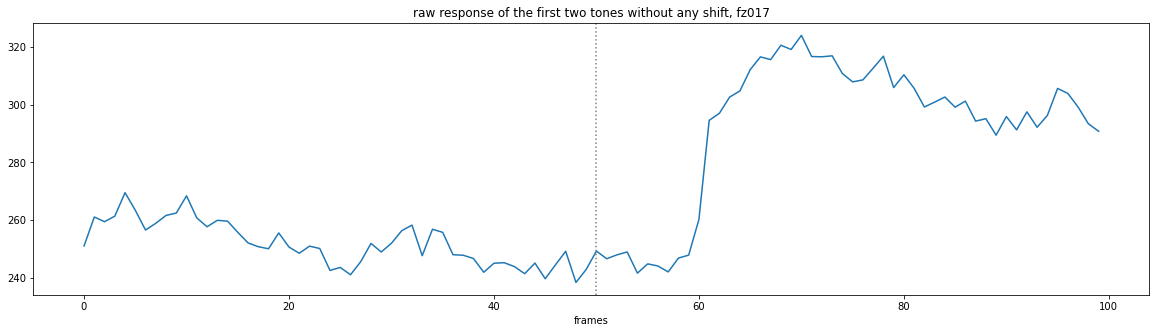

In [250]:
resp = np.mean(F, axis=0)
plt.figure(figsize=(20,5))
plt.plot(np.arange(100), resp[:100])
plt.axvline(50, color='gray', linestyle=':')
plt.xlabel('frames')
plt.title('raw response of the first two tones without any shift, {}'.format(mouse_name))

In [251]:
day0_ind = np.where(param[:, 0] == 0)[0]
day0_plane = param[day0_ind, 2] # plane 1 or 2
day0_data = F[day0_ind]
print(day0_data.shape)
from scipy.stats import zscore
day0_data = zscore(day0_data, axis=1)
def remove_nan(response):
    '''
    remove rows contain nan
    '''
    nanflag = np.isnan(np.sum(response, axis=1))
    print(nanflag.shape)
    notnanflag = np.where(nanflag==False)[0]
    print(notnanflag.shape)
    return response[notnanflag]

day0_data = remove_nan(day0_data)
day0_data = day0_data.reshape((len(day0_data), -1, 50))

(570, 8500)
(570,)
(285,)


In [252]:
tone_order_repeat = np.round(np.tile(toneorder, 10))
target_ind = np.where(tone_order_repeat==target_freq)[0]
target_resp = day0_data[:, target_ind, :]
NA, NT, NF = target_resp.shape # #axons, #trials, #frames
target_resp = target_resp.transpose(1,0,2)
print(target_resp.shape)


foil_ind = np.where(tone_order_repeat==foil_freq)[0]
foil_resp = day0_data[:, foil_ind, :]
foil_resp = foil_resp.transpose(1,0,2)
print(foil_resp.shape)
# NA, NT, NF = foil_resp.shape # #axons, #trials, #frames

(10, 285, 50)
(10, 285, 50)


Text(0.5, 1.0, 'pretraining tuning curve with CI, fz017')

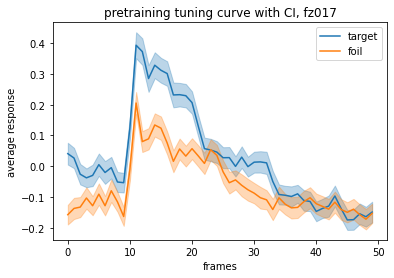

In [253]:
avg_foil_resp = np.mean(foil_resp, axis=0)
avg_target_resp = np.mean(target_resp, axis=0)
target_std = np.std(avg_target_resp, axis=0)
target_y = np.mean(avg_target_resp, axis=0)
foil_std = np.std(avg_foil_resp, axis=0)
foil_y = np.mean(avg_foil_resp, axis=0)
target_ci = 1.96*target_std/np.sqrt(NA)
foil_ci = 1.96*foil_std/np.sqrt(NA)
x = np.arange(50)
plt.plot(x, target_y, label='target', color='C0')
plt.fill_between(x, target_y-target_ci,target_y+target_ci, color='C0', alpha=0.3)
plt.plot(np.arange(50), foil_y, label='foil', color='C1')
plt.fill_between(x, foil_y-foil_ci, foil_y+foil_ci, color='C1', alpha=0.3)
# plt.axvline(15, c='gray', linestyle=':')
plt.legend()
plt.xlabel('frames')
plt.ylabel('average response')
plt.title('pretraining tuning curve with CI, {}'.format(mouse_name))

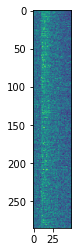

In [254]:
plt.imshow(avg_target_resp)

In [255]:
spks = np.vstack([target_resp.reshape((10, -1)), foil_resp.reshape((10, -1))])
stim = np.zeros(20)
stim[:10] = 1
print(spks.shape)

(20, 14250)


avearge accuracy: 0.41199999999999987


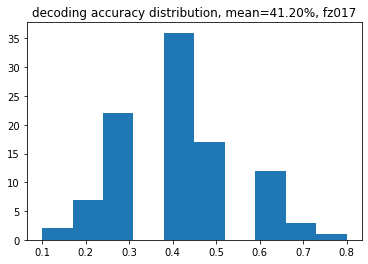

In [256]:
seed = 0
accs = []
for seed in range(100):
    random.seed(seed)
    np.random.seed(seed)
    itrain = np.random.choice(np.arange(2*NT), size=int(NT), replace=False)
    itest = np.setxor1d(np.arange(2*NT), itrain)

    model = LogisticRegression(solver='liblinear', random_state=seed)
    model.fit(spks[itrain], stim[itrain])
    te_pred = model.predict(spks[itest])
    acc = np.sum(te_pred == stim[itest]) / len(itest)
    # print('accuracy predicting stimulus identity on test set: ', acc)
    stim_weights = model.coef_.reshape((NA, NF))
    accs.append(acc)
print('avearge accuracy:', np.mean(accs))
plt.hist(accs, bins=10)
plt.title('decoding accuracy distribution, mean={:.2f}%, {}'.format(np.mean(accs)*100, mouse_name))
plt.show()